In [31]:
!pip install -U imbalanced-learn

In [38]:
!pip install uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import uproot

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
file_path1 = "/content/drive/MyDrive/Colab Notebooks/Bkg_DstarToD0Pi.root"
file_path2 = "/content/drive/MyDrive/Colab Notebooks/Prompt_DstarToD0Pi.root"
file_path3 = "/content/drive/MyDrive/Colab Notebooks/Nonprompt_DstarToD0Pi.root"
name1='bkg'
name2='prompt'
name3='nonprompt'

# open the file
f1 = uproot.open(file_path1)
f2 = uproot.open(file_path2)
f3 = uproot.open(file_path3)

topo_vars = [
    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0"
]

kin_vars = [
    "fPt",
    "fM",
    "fMD0",
    "fInvDeltaMass"
]

para=topo_vars+kin_vars

In [8]:
tree1=f1['treeMLDstar']
tree2=f2['treeMLDstar']
tree3=f3['treeMLDstar']
branches1=tree1.arrays(topo_vars + kin_vars, library="pd")
branches2=tree2.arrays(topo_vars + kin_vars, library="pd")
branches3=tree3.arrays(topo_vars + kin_vars, library="pd")

In [9]:
branches1['label']=0
branches2['label']=1
branches3['label']=2

df=pd.concat((branches1,branches2,branches3),ignore_index=True)

After running the above cell and following the prompts to authorize Google Drive access, your Drive will be mounted at `/content/drive`. You can then access your files using paths like `/content/drive/MyDrive/your_folder/your_file.csv`.

In [10]:
df.head()

,fCpaD0,fCpaXYD0,fDecayLengthXYD0,fImpactParameterProductD0,fImpParamSoftPi,fMaxNormalisedDeltaIPD0,fPt,fM,fMD0,fInvDeltaMass,label
0,0.824643,0.890379,0.015643,0.000010,-0.002355,2.690436,1.190344,2.105395,1.938962,0.166433,0
1,0.917777,0.905826,0.226232,-0.000314,0.001739,35.127995,2.107522,2.045358,1.887015,0.158342,0
2,0.808133,0.738674,0.007805,0.000013,0.009605,2.846718,2.476917,1.945077,1.788784,0.156293,0
3,0.919379,0.945997,0.012752,0.000001,-0.020536,-1.981847,1.451029,2.021622,1.857827,0.163795,0
4,0.955172,0.950172,0.015169,0.000009,-0.013208,1.605553,1.048973,1.979299,1.810297,0.169002,0


In [11]:
df.columns

Index(['fCpaD0', 'fCpaXYD0', 'fDecayLengthXYD0', 'fImpactParameterProductD0',
       'fImpParamSoftPi', 'fMaxNormalisedDeltaIPD0', 'fPt', 'fM', 'fMD0',
       'fInvDeltaMass', 'label'],
      dtype='object')

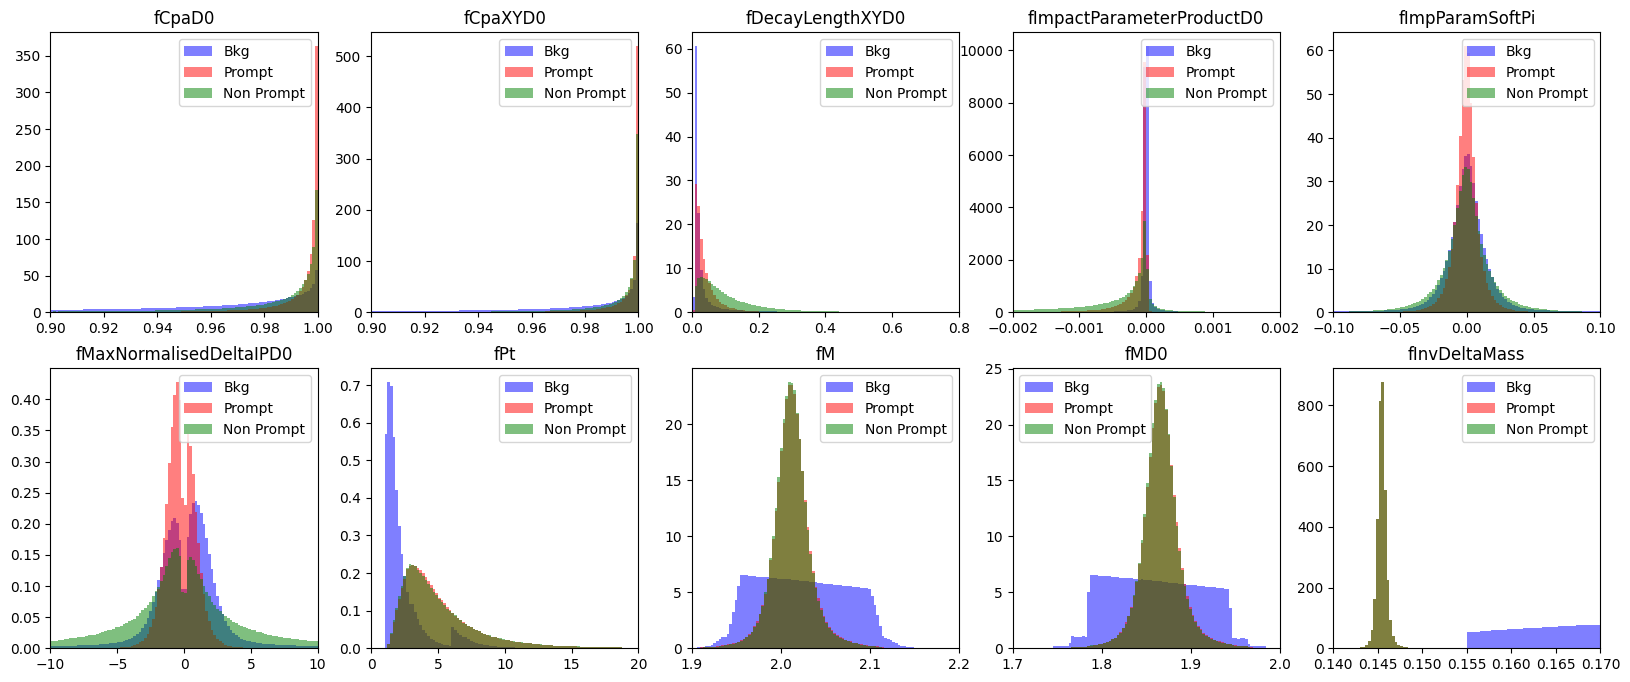

In [12]:
fig,axs=plt.subplots(2,5,figsize=(20,8))
axs=axs.flatten()
xlims = {
    "fCpaD0": (0.9, 1.0),
    "fCpaXYD0": (0.9, 1.0),
    "fDecayLengthXYD0": (0, 0.8),
    "fImpactParameterProductD0": (-0.002, 0.002),
    "fImpParamSoftPi" : (-0.1,0.1),
    "fMaxNormalisedDeltaIPD0" : (-10,10),
    "fPt": (0, 20),
    "fM": (1.9, 2.2),
    "fMD0": (1.7, 2.0),
    "fInvDeltaMass" : (0.14,0.17)
}

for i in range(10):

    #bins = common_bins(branches1[para[i]],branches2[para[i]],branches3[para[i]])
    #bins=300
    bins=np.linspace(xlims[para[i]][0],xlims[para[i]][1],101)
    axs[i].hist(branches1[para[i]],bins=bins,alpha=0.5,color='blue',label='Bkg',density=True)
    axs[i].hist(branches2[para[i]],bins=bins,alpha=0.5,color='red',label='Prompt',density=True)
    axs[i].hist(branches3[para[i]],bins=bins,alpha=0.5,color='green',label="Non Prompt",density=True)
    axs[i].set_title(para[i])
    axs[i].set_xlim(xlims.get(para[i], None))
    axs[i].legend()
plt.show()

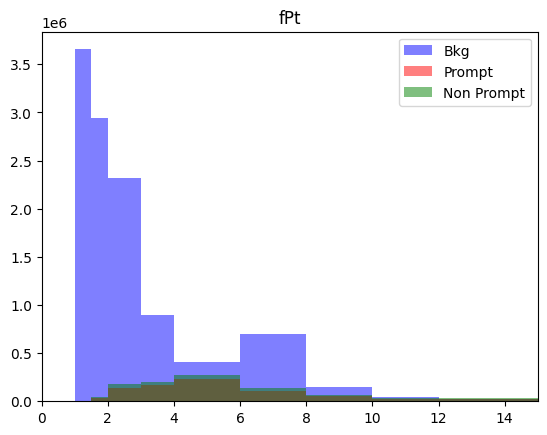

In [13]:
bins=[1, 1.5, 2, 3, 4, 6, 8, 10, 12, 16, 24]
plt.hist(branches1["fPt"],alpha=0.5,bins=bins,color='blue',label='Bkg',density=False)
plt.hist(branches2["fPt"],alpha=0.5,bins=bins,color='red',label='Prompt',density=False)
plt.hist(branches3["fPt"],alpha=0.5,bins=bins,color='green',label="Non Prompt",density=False)
plt.title("fPt")
plt.legend()
plt.xlim(0,15)
plt.show()

In [14]:
#separating data with "fPt" between 4 and 6

pt_min, pt_max =4,6

data = df[(df['fPt'] >= pt_min) & (df['fPt'] < pt_max)]

In [15]:
#splitting binned dataset into training and testing set

train,test = train_test_split(data,test_size=0.3,stratify=(data["label"]),random_state=42)

X_temp=train[topo_vars]
y_temp=train['label']
X_test=test[topo_vars]
y_test=test['label']

over = RandomOverSampler()
X_train,y_train = over.fit_resample(X_temp,y_temp)
#X_train,X_valid,y_train,y_valid = train_test_split(X_temp,y_temp,test_size=0.1,random_state=42)

In [16]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [17]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(16, activation='relu'), # if x <= 0 --> 0, x > 0 --> x
                             tf.keras.layers.Dense(16, activation='relu'),
                             tf.keras.layers.Dense(3, activation="softmax")
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.evaluate(X_train, y_train)

26809/26809 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.3616 - loss: 1.1460


[1.133599042892456, 0.3376300632953644]

In [20]:
model.evaluate(X_test, y_test)

8496/8496 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.3675 - loss: 1.1475


[1.1475387811660767, 0.3680107891559601]

In [21]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.7042 - loss: 0.6862
Epoch 2/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.7483 - loss: 0.6062
Epoch 3/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.7527 - loss: 0.5940
Epoch 4/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.7554 - loss: 0.5871
Epoch 5/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.7555 - loss: 0.5843
Epoch 6/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.7561 - loss: 0.5833
Epoch 7/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - accuracy: 0.7570 - loss: 0.5798
Epoch 8/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.7575 - loss: 0.5794
Epoch 9/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.7580 - loss: 0.5779
Epoch 10/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.7590 - loss: 0.5760
Epoch 11/20
26809/26809 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.7596 - loss: 0.57

In [22]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/model1.pkl", "wb") as f:
    pickle.dump(model,f)

In [28]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/model1.pkl", "rb") as f:
    model = pickle.load(f)

In [29]:
model.evaluate(X_test, y_test)

8496/8496 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7746 - loss: 0.5533


[0.5553938150405884, 0.7732372283935547]

In [37]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

val_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

8496/8496 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Validation Accuracy: 0.7732

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84    122552
           1       0.60      0.75      0.67     68024
           2       0.85      0.72      0.78     81272

    accuracy                           0.77    271848
   macro avg       0.77      0.76      0.76    271848
weighted avg       0.79      0.77      0.78    271848



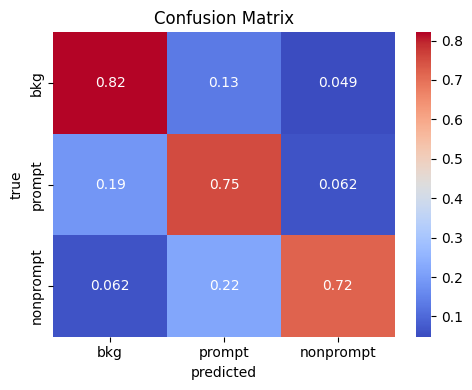

In [39]:
# Confusion Matrix
conf=confusion_matrix(y_test, y_pred,normalize='true')
plt.figure(figsize=(5,4))
ax=sns.heatmap(conf, annot=True, cmap="coolwarm")
ax.set_xticklabels([name1,name2,name3])
ax.set_yticklabels([name1,name2,name3])
plt.title("Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("true")
plt.tight_layout()
plt.show()


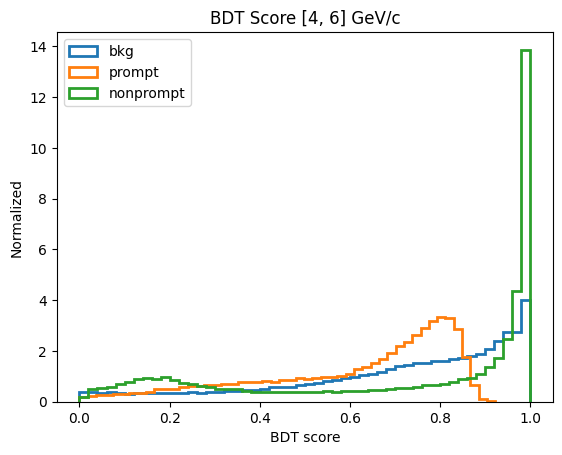

In [42]:

#plotting BDT Scores
scores= y_pred_proba
plt.hist(scores[y_test==0 , 0],bins=50,density=True,histtype="step",linewidth=2,label="bkg")
plt.hist(scores[y_test==1 , 1],bins=50,density=True,histtype="step",linewidth=2,label="prompt")
plt.hist(scores[y_test==2 , 2],bins=50,density=True,histtype="step",linewidth=2,label="nonprompt")
plt.title(f"BDT Score [{pt_min}, {pt_max}] GeV/c")
plt.xlabel("BDT score")
plt.ylabel("Normalized")
plt.legend()
plt.show()

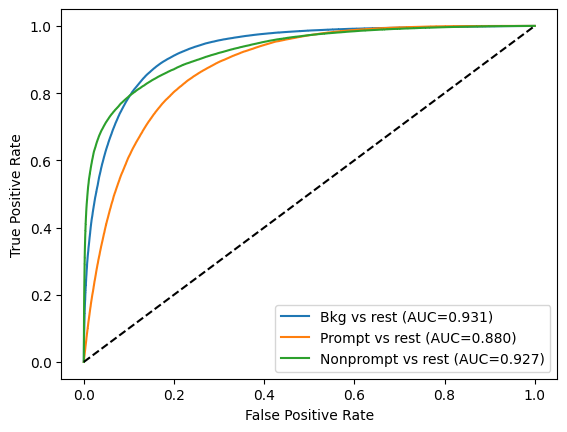

In [44]:
#plotting ROC curves

for k, name in zip([0,1,2], ["Bkg","Prompt","Nonprompt"]):
    y_true = (y_test == k).astype(int)
    y_score = scores[:, k]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{name} vs rest (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#function to plot pairwise roc
def pairwise_roc(y_true, y_proba, class_sig, class_bkg, label):
    """
    y_true  : true labels
    y_proba : predict_proba output
    class_sig : signal class label
    class_bkg : background class label
    label : legend label
    """

    mask = (y_true == class_sig) | (y_true == class_bkg)

    y_bin = (y_true[mask] == class_sig).astype(int)
    score = y_proba[mask, class_sig]

    fpr, tpr, _ = roc_curve(y_bin, score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f"{label} (AUC = {roc_auc:.3f})")

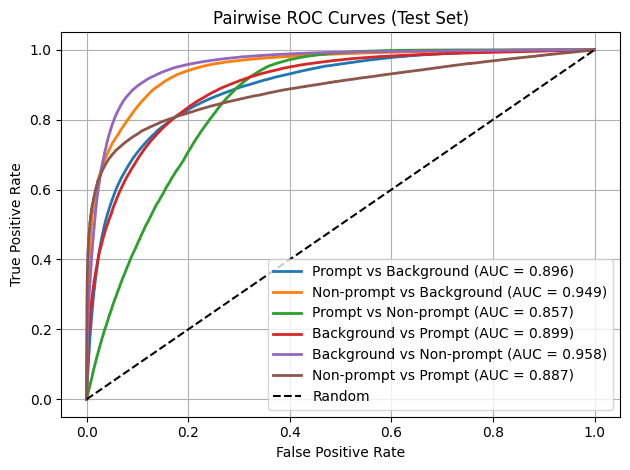

In [48]:
y_proba=scores
pairwise_roc(y_test, y_proba, 1, 0, "Prompt vs Background")
pairwise_roc(y_test, y_proba, 2, 0, "Non-prompt vs Background")
pairwise_roc(y_test, y_proba, 1, 2, "Prompt vs Non-prompt")
pairwise_roc(y_test, y_proba, 0, 1, "Background vs Prompt")
pairwise_roc(y_test, y_proba, 0, 2, "Background vs Non-prompt")
pairwise_roc(y_test, y_proba, 2, 1, "Non-prompt vs Prompt")

plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pairwise ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
